<br/><br/>
<h1 align="center">Finding Relevant Information in Big Datasets with ML</h1> 
<br/><br/>
<h3 align="center">Authors:</h3> 
<h3 align="center">Uchechukwu Njoku, Alberto Abelló, Besim Bilalli, Gianluca Bontempi</h3> 
<h4 align="center">EDBT 2024</h4> 
<h4 align="center">Paestum, Italy</h4> 
<h4 align="center">27<sup>th</sup> March, 2024</h4> 

In [142]:
# Import all required libraries
import time
import random
import logging
import numpy as np
import pandas as pd
import openml as oml 
from sklearn import svm
from pathlib import Path
from sklearn import tree
from tabulate import tabulate
from matplotlib import pyplot as plt
from sklearn.naive_bayes import GaussianNB
from jmetal.core.problem import BinaryProblem
from jmetal.core.solution import BinarySolution
from IPython.display import IFrame, display, HTML
from sklearn.ensemble import RandomForestClassifier
from fairlearn.metrics import demographic_parity_ratio
from jmetal.algorithm.multiobjective.nsgaii import NSGAII
from traitlets.config.manager import BaseJSONConfigManager
from skfeature.function.statistical_based import gini_index
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.algorithm.singleobjective.genetic_algorithm import GeneticAlgorithm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from jmetal.util.termination_criterion import StoppingByEvaluations, StoppingByTime
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from jmetal.operator import SBXCrossover, PolynomialMutation, SPXCrossover, BitFlipMutation
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS, SequentialFeatureSelector as SFS

## Notebook on GitHub

<center>   
<img src="./images/qr-code.png" alt="transition" width="450" height="250">
</center>

### URL: https://github.com/F-U-Njoku/fs_tutorial

**Content:**
<br></br>
1. Introduction to Feature Selection (FS)
2. Search strategies
3. FS classes
4. Evaluation metrics
5. Open challenges
6. Conclusion

## Where we are: Data abundance

- Increased Data Generation
<br/><br/>
- Data Variety
<br/><br/>
- Advanced in Storage and Processing Technologies
<br/><br/>
- Decreasing Storage Costs
<br/><br/>
- Organizational Culture and Skills
<br/><br/>
- Business Value

<br/><br/>
<center>
<img src="./images/ezgif.com-effects.gif" alt="Big data" width="450" height="250"/>
<center/>

In [36]:

# Define the URL for the iframe
url = "https://wall.sli.do/event/wT2yM4CDVA39n1XggtSeNg?section=769d6d7d-76ba-48da-9cad-c72b102daa84"
# Create the IFrame
iframe = IFrame(url, width=600, height=800)
# Define HTML/CSS to center the iframe
slido1 = """
<div style="display: flex; justify-content: center;">
    {}
</div>
""".format(iframe._repr_html_())

# Join at slido.com #2198 009
<br></br>
<center>   
<img src="./images/slido1.png" alt="transition" width="600" height="450">
</center>

In [37]:
# Display Slido poll results
display(HTML(slido1))

## Challenges
1. High dimensionality
<br/><br/>
2. Feature redundancy
<br/><br/>
3. Irrelevance features
<br/><br/>
4. Long processing time
<br/><br/>
5. Reduced data and model understanding
<br/><br/>
6. Storage and computational cost

<br></br>
<center>
<img src="./images/difficulties.png" alt="challenges" width="450" height="600"/>
<center/>

## Necessary transition
<center>   
<img src="./images/Experimental Design1.png" alt="transition" width="1440" height="810">
</center>

## Necessary transition
<center>   
<img src="./images/Experimental Design2.png" alt="transition" width="1440" height="810">
</center>

## Feature selection (FS)

Feature selection is **a search problem of detecting the relevant features and discarding the irrelevant and redundant ones** with the goal of obtaining a subset of features that accurately describe a given problem with a minimum degradation of performance.
<center>   
<img src="./images/fs.png" alt="transition" width="960" height="540">
</center>

## Feature selection (FS)
<center>   
<img src="./images/featureselection.png" alt="transition" width="1440" height="810">
</center>

## Running example
**German Credit dataset:** this dataset classifies people described by a set of attributes as good or bad credit risks.

- 21 features
- Sensitive: personal_status
- Target: credit
- 1,000 instances
- 1,048,574 possible solutions

In [2]:
# Uncomment to install
#!pip install openml


  
# function to retrieve data    
def fetch_data(number):
    dataset = oml.datasets.get_dataset(number, download_data=True, 
                                       download_qualities=True, 
                                       download_features_meta_data=True)
    X, y, attribute_names, categorical_indicator,  = dataset.get_data(
        dataset_format="dataframe",
        target=dataset.default_target_attribute)
    return X, y, attribute_names, len(attribute_names)

# fetch dataset 
data, y, attribute_names, z = fetch_data(43808)

In [3]:
data.head()

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


In [4]:
# Rename columns
data.rename(columns={'laufkont':"checking_status", 
                  'laufzeit':"duration", 
                  'moral':"credit_history", 
                  'verw':"purpose", 
                  'hoehe':"credit_amount", 
                  'sparkont':"savings_status", 
                  'beszeit':"employment",
                  'rate':"installment_commitment", 
                  'famges':"personal_status", 
                  'buerge':"other_parties",
                  'wohnzeit':"residence_since", 
                  'verm':"property_magnitude", 
                  'alter':"age", 
                  'weitkred':"other_payment_plans",
                  'wohn':"housing", 
                  'bishkred':"existing_credits", 
                  'beruf':"job", 
                  'pers':"num_dependents", 
                  'telef':"own_telephone", 
                  'gastarb':"foreign_worker",
                  'kredit':"credit"}, inplace=True)

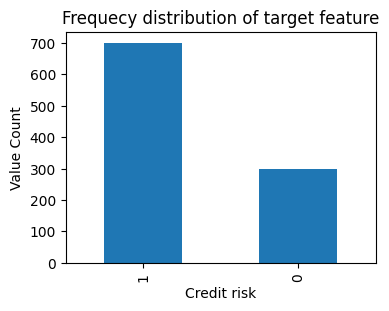

In [5]:
plot = data['credit'].value_counts().plot(kind='bar', title="Frequecy distribution of target feature", xlabel="Credit risk", ylabel="Value Count", figsize=(4,3))

In [6]:
data.sample(3)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,credit
984,1,48,2,3,6999,1,4,1,4,3,...,1,34,3,2,2,3,2,2,2,0
453,2,24,4,6,5743,1,2,2,2,1,...,4,24,3,3,2,3,2,2,2,1
172,3,12,2,3,1297,1,3,3,4,1,...,1,23,3,1,1,3,2,1,2,1


In [7]:
# Display data
X = data.drop(["credit"], axis=1)
y = data["credit"]

In [8]:
# Predictors
X.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,1,18,4,2,1049,1,2,4,2,1,4,2,21,3,1,1,3,2,1,2
1,1,9,4,0,2799,1,3,2,3,1,2,1,36,3,1,2,3,1,1,2
2,2,12,2,9,841,2,4,2,2,1,4,1,23,3,1,1,2,2,1,2
3,1,12,4,0,2122,1,3,3,3,1,2,1,39,3,1,2,2,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,4,2,38,1,2,2,2,2,1,1


In [9]:
# Target
y.sample(5)

367    1
112    1
685    1
373    1
771    0
Name: credit, dtype: uint8

### Classifier 

In [116]:
# Naive Bayes Classifier
nb = GaussianNB()

### Predictive performance metrics
- Accuracy
- Precision
- Recall
- Specificity
- F1 score
- **ROC AUC**

**ROC AUC**
<br></br>
<center>   
<img src="./images/AUC.svg" alt="transition" width="470.25" height="405.75">
</center>

Preferable for unbalanced data.

## Baseline: Full Dataset
<center>   
<img src="./images/gif3.png" alt="transition" width="374" height="386">
</center>

In [25]:
%%time
# Build classifier with all features
baseline = cross_val_score(estimator=nb,X=X, y=y,
                scoring="roc_auc", cv=2).mean()

print('AUC score with full dataset: %.2f%%' %(baseline*100))

AUC score with full dataset: 72.21%
CPU times: user 38.9 ms, sys: 0 ns, total: 38.9 ms
Wall time: 43.8 ms


**Content:**
<br></br>
1. Introduction to Feature Selection (FS)
2. Search strategies
    * Exponential
    * Sequential
    * Heuristics-based
3. FS classes
4. Evaluation metrics
5. Open challenges
6. Conclusion

## Exponential search
Evaluates an increasing number of subsets which scales exponentially with the size of the feature space.
<br><br/>

1. Traverses the entire search
2. Near guarantee of best solution
3. Computationally expensive
3. Feasible for small datasets
<br><br/>
    E.g: Exhaustive search, Branch-and-bound

<center>
<img src="./images/exhaustive.png" alt="exaustive search" width="528" height="338">
<center/>

### Brand-and-bound
- Follows a tree structure
- The root comprises all features
- The intermediate child node contains a feature subset one smaller than its parent node
- Can be constrained to a predetermined size for the feature subset
- Top-down with backtracking

<center>
<img src="./images/bb.gif" alt="Big data" width="927" height="436"/>
<center/>

### Applying Exhaustive search

In [86]:
%%time
# Exhaustive search
efs1 = EFS(nb, 
           min_features=1,
           max_features=20,
           scoring='roc_auc',
           print_progress=False,
           cv=2)

# Estimated execution time is 1 hour.
efs1 = efs1.fit(X, y.values.ravel())
print('Best AUC score: %.2f%%' % (efs1.best_score_*100))
print('Number of features:', len(efs1.best_idx_))

Best AUC score: 0.78
Number of features: 9
CPU times: user 50min 33s, sys: 3.42 s, total: 50min 36s
Wall time: 50min 37s


## Sequential search
Simple greedy algorithms that consecutively update the feature subset with features that improve or maintain the evaluation criterion.
<br><br/>

1. Simple
2. Greedy algorithms
3. Resilience against overfitting
4. Best solution not guaranteed
<br><br/>
    E.g: Sequential Forward Selection, Sequential Backward Selection

<center>
<img src="./images/sequential.png" alt="exaustive search" width="528" height="338">
 </center>

### Sequential Forward Selection
- Size = 2
- Starts with the empty set - {}
<br/><br/>
<center>
<img src="./images/sfs.gif" alt="Big data" width="528" height="338"/>
<center/>

### Sequential Backward Selection
- Size = 2
- Starts with the full set of features - {f1, f2, f3, f4}
<br/><br/>
<center>
<img src="./images/sbs.gif" alt="Big data" width="528" height="338"/>
<center/>

### Applying Sequential Foward Selection

In [68]:
%%time
# Sequential Foward Selection
sfs1 = SFS(nb, 
           k_features=9, 
           forward=True, 
           scoring='roc_auc',
           cv=2)

sfs1 = sfs1.fit(X, y)
print('Best AUC score: %.2f%%' % (sfs1.k_score_*100))

Best AUC score: 77.68%
CPU times: user 861 ms, sys: 2.76 ms, total: 864 ms
Wall time: 875 ms


## Heuristics-based search
Integrate randomness into their search process through heuristics to navigate large search spaces and avoid local minima. 

1. Heuristics that imitate natural population evolution
2. Wider exploration of search space
3. Trap in local optimum

E.g: Particle swarm optimisation, genetic algorithms

<center>
<img src="./images/population-based.png"  alt="exaustive search"  width="528" height="338">
 </center>

### Genetic algorithm (GA)
GA entities:
- Chromosomes --> Subset of features
- Genes ------------> Features
- Alleles -----------> Selection indication (0 or 1)
Steps:
1. **Initialization:** initialize population of candidate solutions
2. **Evaluaton:** measure the fitness of each candidate solution
3. **Selection:** survival of the fittest to keep 'better' solutions
4. **Recombination:** a crossover of the selected solutions to form new/better solutions
5. **Mutation:** local and random modification of a solution to add diversity
6. **Replacement:** replace current population with created offspring
7. Repeat 2 - 6 until termination criterion is satisfied

In [71]:
class credit(BinaryProblem):
    
    def __init__(self, pred: pd.DataFrame, target: pd.Series, classifier, n_var:int=20):
        super(credit, self).__init__()
        self.pred = pred
        self.target = target
        self.classifier = classifier
        self.n_var = n_var
        self.obj_labels = ["auc"]
        
    def number_of_variables(self) -> int:
        return 1
    def number_of_objectives(self) -> int:
        return 1
    def number_of_constraints(self) -> int:
        return 1
        
    def evaluate(self, solution: BinarySolution) -> BinarySolution:
        
        # check constraint and if violated generate a new solution
        self.__evaluate_constraints(solution)
        if solution.constraints[0] == 0:
            check = random.randrange(self.n_var)
            solution.variables[0] = [True if _ == check else False for _ in range(self.n_var)]
       
        auc = cross_val_score(estimator=self.classifier, 
                                   X=self.pred.iloc[:,solution.variables[0]], y=self.target,
                                   scoring="roc_auc", cv=2).mean()
        solution.objectives[0] = auc * -1.0
        return solution
        
    def __evaluate_constraints(self, solution: BinarySolution) -> None:
        solution.constraints = [0 for _ in range(self.number_of_constraints())]
        if sum(solution.variables[0]) == 0:
            solution.constraints[0] = 0
        else:
            solution.constraints[0] = 1
        
    def create_solution(self) -> BinarySolution:
        new_solution = BinarySolution(number_of_variables=self.number_of_variables(),
                                      number_of_objectives=self.number_of_objectives())
        new_solution.variables[0] =  [True if random.randint(0, 1) == 1 else 
                                      False for _ in range(self.n_var)]
        return new_solution
    
    def name(self) -> str:
        return 'Credit'
logging.disable()

### Applying  Genetic Algorithm

In [72]:
%%time
# Genetic algorithm
problem = credit(X, y, nb)
algorithm = GeneticAlgorithm(
        problem=problem,
        population_size=40,
        offspring_population_size=40,
        mutation=BitFlipMutation(1.0 / problem.n_var),
        crossover=SPXCrossover(1.0),
        termination_criterion=StoppingByEvaluations(max_evaluations=20000),
    )
# Estimated execution time is 2 mins.
algorithm.run()
result = algorithm.get_result()
indices = [int(i) for i in range(len(result.get_binary_string())) if result.get_binary_string()[i] == "1"]

CPU times: user 3min 16s, sys: 0 ns, total: 3min 16s
Wall time: 3min 16s


In [74]:
print('Best AUC score: %.2f%%' % (result.objectives[0]*-100))
print('Number of features:', len(indices))

Best AUC score: 77.75%
Number of features: 9


## Summary
- In the context of big data, exponential search is infeasible.
- The outcome of exponential and sequential methods are deterministic.
- In general, feature selection may improve performance and model understanding.

|Measure | Baseline |Exponential  | Sequential    | Heuristics-based  
|---:|-------------|:-------------|:-----------|:------|
| AUC|72.21%| 78 % |    77.68%   |  77.75%  | 
| Size| 20|9 |    9    |   9 | 
| Time |43.8 ms| 50 mins  | 875 ms    |  3 mins | 

**Content:**
<br></br>
1. Introduction to Feature Selection (FS)
2. Search strategies
3. FS classes
    * Filter methods
    * Wrapper methods
    * Embeded methods
    * Hybrid methods
4. Evaluation metrics
5. Open challenges
6. Conclusion

In [75]:

# Define the URL for the iframe
url = "https://wall.sli.do/event/4x1hRrKH2aAagWbB3j4XA1?section=b8b6bb36-55a1-44f9-9680-2895646ddf65"
# Create the IFrame
iframe = IFrame(url, width=600, height=800)
# Define HTML/CSS to center the iframe
slido2 = """
<div style="display: flex; justify-content: center;">
    {}
</div>
""".format(iframe._repr_html_())

# Join at slido.com #2256 105
<br></br>
<center>   
<img src="./images/slido2.png" alt="transition" width="450" height="250">
</center>

In [35]:
# Display Slido poll resutls
display(HTML(slido2))

## Filter methods
Evaluate and select features independent of any learning algorithm by solely relying on the characteristics of the dataset to determine the relevance of a feature.

<center>
<img src="./images/filter.png" align="left" alt="filter" width="528" height="338">
</center>

1. Fast execution time
2. Good generalization
3. Robust to overfitting
4. Possible redundancy 
5. Model independent
6. Non ‘optimal’ selection

E.g: Gini, Mutual information, Correlation measures

**Similarity-Based Filter Methods**
- Laplacian Score
- Fisher Score
- Trace Ratio Criterion
- ReliefF

**Information-Theoretical-Based Filter Methods**
- Information Gain
- Minimum Redundancy Maximum Relevance (MRMR)
- Joint Mutual Information
- Fast Correlation-Based Filter

**Sparse-Learning-Based Filter Methods**
- Feature Selection with Lp -Norm Regularizer.
- Efficient and Robust Feature Selection
- Feature Selection Using Nonnegative Spectral Analysis

**Statistical-Based Filter Methods**
- Low Variance
- T-Score
- Chi-Square Score
- Gini Index

### Gini index
A statistical-based measure used to assess whether a feature effectively distinguishes instances belonging to different classes. The lower the Gini index value, the more relevant the feature is.

### Applying  Gini Index

In [91]:
%%time
score = gini_index.gini_index(X.values, y.values)
# rank features in descending order according to score
idx = gini_index.feature_ranking(score)
sorted(zip(X.columns, score),key=lambda x: x[1])

CPU times: user 33.9 ms, sys: 3 µs, total: 33.9 ms
Wall time: 34.5 ms


[('checking_status', 0.3720903804538366),
 ('credit_history', 0.40293787540546877),
 ('savings_status', 0.40519357884796975),
 ('duration', 0.4063784549964565),
 ('credit_amount', 0.4089123232700295),
 ('age', 0.4131254061078623),
 ('property_magnitude', 0.41335850910319),
 ('employment', 0.41419963848162283),
 ('other_payment_plans', 0.4146099178357242),
 ('purpose', 0.4160563254558033),
 ('personal_status', 0.4161718750000001),
 ('housing', 0.4163841615688729),
 ('foreign_worker', 0.4171704414695068),
 ('installment_commitment', 0.4178956315350569),
 ('other_parties', 0.4187276858162934),
 ('existing_credits', 0.4191217807163674),
 ('job', 0.41930909783022463),
 ('own_telephone', 0.41944149112897866),
 ('residence_since', 0.4198408488063661),
 ('num_dependents', 0.4199961824775721)]

#### Top - 9

In [77]:
top_9 = ['checking_status','credit_history','savings_status', 'duration','credit_amount', 
'age','property_magnitude', 'employment', 'other_payment_plans']
auc = cross_val_score(estimator=nb,X=X.loc[:,top_9], y=y,
                scoring="roc_auc", cv=2).mean()
print('Filter --> AUC score with top 9 features: %.2f%%' %(auc*100))

Filter --> AUC score with top 9 features: 76.54%


## Wrapper methods
Depend on the performance metrics (e.g., accuracy or AUC) of a chosen Machine Learning (ML) algorithm to evaluate generated feature subsets.

<center>
<img src="./images/wrapper.png" alt="wrapper" width="604" height="406">
</center>

1. Model dependent
2. High accuracy 
3. Captures dependencies
4. Poor generalization
5. Risk of overfitting
6. Computationally intense

E.g: ML performance metrics

### Applying Wrapper with NB AUC

In [78]:
%%time
# Nine features
sfs1 = SFS(nb, 
           k_features=9, 
           forward=True, 
           scoring='roc_auc',
           cv=2)

sfs1 = sfs1.fit(X, y)
print('Wrapper --> AUC score with top 9 features: %.2f%%' % (sfs1.k_score_*100))

Wrapper --> AUC score with top 9 features: 77.68%
CPU times: user 856 ms, sys: 3.81 ms, total: 860 ms
Wall time: 865 ms


## Embedded methods
ML algorithms that intrinsically do feature selection while building the model.
<br></br>

<center>
<img src="./images/embedded.png" alt="embedded" width="532" height="284">
</center>


1. Model dependent
2. Moderate execution time
3. Captures dependencies
4. Poor generalization


E.g: Tree based algorithms, LASSO Regression

### Decision Tree Embedded Method
Recursively partitions the feature space into subsets, making decisions based on the values of features to classify instances into different classes. Split criteria includes: Gini, Entropy, Log_loss.

In [86]:
clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=3)
clf = clf.fit(X, y)

In [87]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                   feature_names=X.columns,  
                   filled=True, rounded=True,  
                    special_characters=True)  
graph = graphviz.Source(dot_data) 

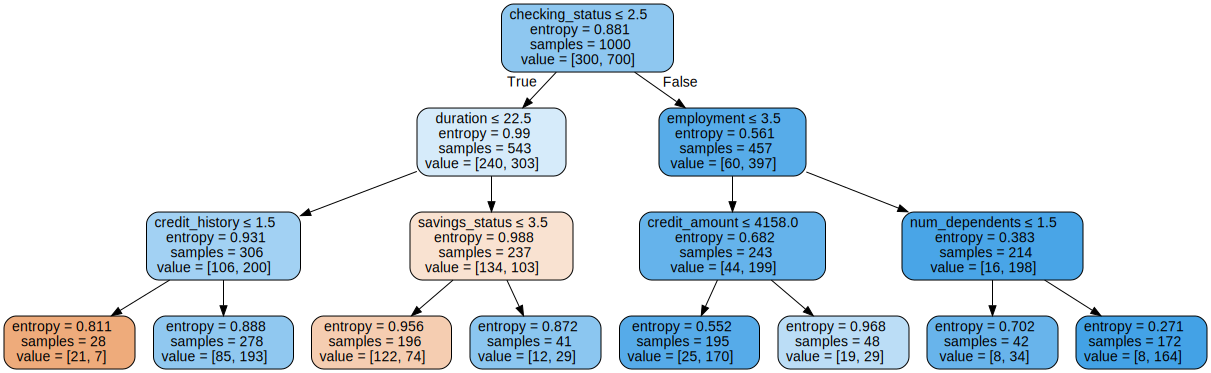

In [88]:
graph

### Build full tree

In [94]:
full = tree.DecisionTreeClassifier(criterion="entropy")
full = full.fit(X, y)
tree_importances = pd.Series(full.feature_importances_, index=X.columns)

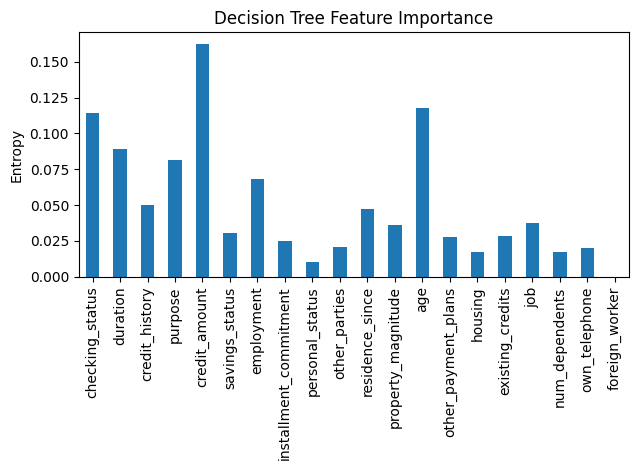

In [111]:
# Decision Tree Feature Importance
fig, ax = plt.subplots()
tree_importances.plot.bar(y=tree_importances, ax=ax)
ax.set_title("Decision Tree Feature Importance")
ax.set_ylabel("Entropy")
fig.tight_layout()

#### Baseline

In [125]:
%%time
baseline = cross_val_score(estimator=full,X=X, y=y,
                scoring="roc_auc", cv=2).mean()


print('Embedded --> AUC score with full dataset: %.2f%%' %(baseline*100))

Embedded --> AUC score with full dataset: 59.86%
CPU times: user 13.3 ms, sys: 476 µs, total: 13.8 ms
Wall time: 12.7 ms


### DT Embedded Top - 9 

In [139]:
%%time
top_9 = ['credit_amount', 'age','checking_status', 'duration', 'purpose',
         'employment', 'credit_history','residence_since', 'job']
auc = cross_val_score(estimator=full,X=X.loc[:,top_9], y=y,
                scoring="roc_auc", cv=2).mean()


print('Embedded --> AUC score with top 9 features %.2f%%' %(baseline*100))

Embedded --> AUC score with top 9 features 59.86%
CPU times: user 37.9 ms, sys: 2.08 ms, total: 40 ms
Wall time: 37 ms


In [98]:
# The higher the score value, the more relevant the feature is.
sorted(zip(X.columns, full.feature_importances_),key=lambda x: x[1], reverse=True)

[('credit_amount', 0.16245323776661666),
 ('age', 0.11760606167786071),
 ('checking_status', 0.11414817380707558),
 ('duration', 0.08947210130432658),
 ('purpose', 0.0813063907715459),
 ('employment', 0.06827072290546635),
 ('credit_history', 0.04988349417445531),
 ('residence_since', 0.047170717926151996),
 ('job', 0.03737724347415575),
 ('property_magnitude', 0.035916783231973004),
 ('savings_status', 0.030421743991744372),
 ('existing_credits', 0.028406246069433427),
 ('other_payment_plans', 0.027488354115250628),
 ('installment_commitment', 0.024723065507404236),
 ('other_parties', 0.02051975789311336),
 ('own_telephone', 0.019998469473311676),
 ('num_dependents', 0.01748168040978599),
 ('housing', 0.016912814893652685),
 ('personal_status', 0.010442940606675893),
 ('foreign_worker', 0.0)]

In [123]:
%%time
# Tree 
top_9 = ['checking_status','duration','credit_amount', 'credit_history',
         'savings_status','age','property_magnitude', 'purpose','installment_commitment'] 
auc = cross_val_score(estimator=full,X=X.loc[:,top_9], y=y,
                scoring="roc_auc", cv=2).mean()

print('Embedded --> AUC score with top 9 features: %.2f%%' %(auc*100))

Embedded --> AUC score with top 9 features: 60.98%
CPU times: user 12.7 ms, sys: 5.89 ms, total: 18.6 ms
Wall time: 17 ms


### Applied to NB

In [131]:
%%time
top_9 = ['credit_amount', 'age','checking_status', 'duration', 'purpose',
         'employment', 'credit_history','residence_since', 'job'] 
auc = cross_val_score(estimator=nb,X=X.loc[:,top_9], y=y,
                scoring="roc_auc", cv=2).mean()

print('Embedded --> AUC score with top 9 features: %.2f%%' %(auc*100))

Embedded --> AUC score with top 9 features: 75.87%
CPU times: user 31.1 ms, sys: 2.52 ms, total: 33.6 ms
Wall time: 30.4 ms


## Hybrid methods
Combine multiple classes of feature selection to find the most relevant features from a dataset.

<img src="./images/hybrid.png" align="center" alt="embedded" width="450" height="300" >

- Leverages the complementary strenghts of the FS classes.
- Mitigate limitations of FS classes.
- Examples: Gini + Decision Tree

#### Hybrid Examples
- Filter + Embedded
- Wrapper + Embedded

In [136]:
%%time
Gini_top_9 = ['checking_status','credit_history','savings_status', 'duration','credit_amount', 
'age','property_magnitude', 'employment', 'other_payment_plans']
auc = cross_val_score(estimator=full,X=X.loc[:,Gini_top_9], y=y,
                scoring="roc_auc", cv=2).mean()
print('Hybrid(Gini + DT) --> AUC score with top 9 features: %.2f%%' %(auc*100))

Hybrid(Gini + DT) --> AUC score with top 9 features: 64.57%
CPU times: user 46.6 ms, sys: 0 ns, total: 46.6 ms
Wall time: 45.1 ms


In [137]:
%%time
sfs1 = SFS(full, 
           k_features=9, 
           forward=True, 
           scoring='roc_auc',
           cv=2)

sfs1 = sfs1.fit(X, y)
print('Hybrid(Wrapper-AUC + DT) --> AUC score with top 9 features: %.2f%%' % (sfs1.k_score_*100))

Hybrid(Wrapper-AUC + DT) --> AUC score with top 9 features: 63.37%
CPU times: user 942 ms, sys: 0 ns, total: 942 ms
Wall time: 940 ms


## No feature selection?
<center>   
<img src="./images/person.png" alt="transition" width="450" height="250">
</center>

In [46]:
%%time
baseline = cross_val_score(estimator=tree,X=X, y=y,
                scoring="roc_auc", cv=2).mean()


print('AUC score with full dataset: %.4f' %baseline)

AUC score with full dataset: 0.7361
CPU times: user 143 ms, sys: 3.94 ms, total: 147 ms
Wall time: 146 ms


- NB Classifier
|Measure |Baseline| Filter  | Wrapper    | Embedded  
|---:|:-------------|:-------------|:-----------|:------|
| AUC| 72.21%|76.54% |    77.68%    |  75.87%  | 
| Size|    20    |    9    |    9    |   9 | 
| TIme|43.8 ms |34.5 ms |    865 ms   |   30.4 ms| 

- DT Classifier
|Measure |Baseline| Filter-H  | Wrapper-H    | Embedded  
|---:|:-------------|:-------------|:-----------|:------|
| AUC| 59.86%|64.57% |    63.37%   |  59.86%  | 
| Size|    19    |    9    |    9    |   9 | 
| TIme|12.7 ms |45.1 ms |    940 ms    |   37 ms| 

## Summary
- Wrapper methods are the least computationally efficent.
- Filter methods can also be beneficial for embedded models.
- Feature selection does not always improve performance.

**Content:**
1. Introduction to Feature Selection (FS)
2. Search strategies
3. FS classes
4. Evaluation metrics
    - Mono-objective FS
    - Multi-objective FS
    - Many-objective FS
5. Open challenges
6. Conclusion

#### Evaluation metrics
- Predictive Performance
    - Accuracy
    - Precision
    - Recall
    - Specificity
    - F1 score
    - ROC AUC

- Model fairness
    - Statistical Parity
    - Equalized odds

- Model understanding
    - Number of features

- Feature redundancy
    - Correlation measures
    - Variance inflation factor

In [66]:

# Define the URL for the iframe
url = "https://wall.sli.do/event/73ty2hUXdRrxzig7PtxJ3s?section=52ab903f-d0a7-419c-888e-bce22d55cafd"
# Create the IFrame
iframe = IFrame(url, width=600, height=800)
# Define HTML/CSS to center the iframe
slido3 = """
<div style="display: flex; justify-content: center;">
    {}
</div>
""".format(iframe._repr_html_())

# Join at slido.com #3297 347
<br></br>
<center>   
<img src="./images/slido3.png" alt="transition" width="450" height="250">
</center>

In [67]:
# Display the centered iframe
display(HTML(slido3))

## Mono-objective
<center>
<img src="./images/mono.png" align="right" alt="mono" width="532" height="284">
</center>


1. One solution
2. Least complexity
3. Most commonly used


E.g: Predictive performance, filter measures

### All examples seen so far are mono-objective FS

In [148]:
class credit(BinaryProblem):
    
    def __init__(self, pred: pd.DataFrame, target: pd.Series, classifier, n_var:int=20):
        super(credit, self).__init__()
        self.pred = pred
        self.target = target
        self.classifier = classifier
        self.n_var = n_var
        self.obj_labels = ["auc"]
        
    def number_of_variables(self) -> int:
        return 1
    def number_of_objectives(self) -> int:
        return 1
    def number_of_constraints(self) -> int:
        return 1
        
    def evaluate(self, solution: BinarySolution) -> BinarySolution:
        
        # check constraint and if violated generate a new solution
        self.__evaluate_constraints(solution)
        if solution.constraints[0] == 0:
            check = random.randrange(self.n_var)
            solution.variables[0] = [True if _ == check else False for _ in range(self.n_var)]
       
        auc = cross_val_score(estimator=self.classifier, 
                                   X=self.pred.iloc[:,solution.variables[0]], y=self.target,
                                   scoring="roc_auc", cv=2).mean()
        solution.objectives[0] = auc * -1.0
        return solution
        
    def __evaluate_constraints(self, solution: BinarySolution) -> None:
        solution.constraints = [0 for _ in range(self.number_of_constraints())]
        if sum(solution.variables[0]) == 0:
            solution.constraints[0] = 0
        else:
            solution.constraints[0] = 1
        
    def create_solution(self) -> BinarySolution:
        new_solution = BinarySolution(number_of_variables=self.number_of_variables(),
                                      number_of_objectives=self.number_of_objectives())
        new_solution.variables[0] =  [True if random.randint(0, 1) == 1 else 
                                      False for _ in range(self.n_var)]
        return new_solution
    
    def name(self) -> str:
        return 'Credit'
logging.disable()

#### Mono-objective FS Example
- Predictive performance: AUC (↑)

In [149]:
problem = credit(X, y, nb)
algorithm = GeneticAlgorithm(
        problem=problem,
        population_size=40,
        offspring_population_size=40,
        mutation=BitFlipMutation(1.0 / problem.n_var),
        crossover=SPXCrossover(1.0),
        termination_criterion=StoppingByEvaluations(max_evaluations=20000),
    )

algorithm.run()
result = algorithm.get_result()
indices = [int(i) for i in range(len(result.get_binary_string())) if result.get_binary_string()[i] == "1"]

In [150]:
soln_df = pd.DataFrame(columns=["Solution", "AUC"])
soln_df["Solution"] = [1]
soln_df["AUC"] = [result.objectives[0]*-100]

In [151]:

print(tabulate(soln_df.set_index('Solution').round(2), headers = 'keys', tablefmt = 'psql'))
print('Execution time in seconds: %.2f' %(algorithm.total_computing_time))
print('Number of featurea: %.0f' %len(indices))

+------------+-------+
|   Solution |   AUC |
|------------+-------|
|          1 | 77.75 |
+------------+-------+
Execution time in seconds: 199.63
Number of featurea: 9


## Multi-objective
<center>
<img src="./images/multi.png" align="right" alt="multi" width="532" height="284">
</center>

1. Two or three objectives
2. More than one solution
3. High complexity



E.g: Predictive performance and redundancy


### Non-dominated Solutions
Non-dominated solutions are solutions that are superior to others in at least one objective and not inferior in any other objective.
<center>
<img src="./images/pareto.png" alt="pareto" width="594" height="340">
</center>

In [152]:
class credit(BinaryProblem):
    
    def __init__(self, pred: pd.DataFrame, target: pd.Series, classifier, n_var:int=20):
        super(credit, self).__init__()
        self.pred = pred
        self.target = target
        self.classifier = classifier
        self.n_var = n_var
        self.obj_labels = ["auc", "size"]
        
    def number_of_variables(self) -> int:
        return 1
    def number_of_objectives(self) -> int:
        return 2
    def number_of_constraints(self) -> int:
        return 1
        
    def evaluate(self, solution: BinarySolution) -> BinarySolution:
        
        # check constraint and if violated generate a new solution
        self.__evaluate_constraints(solution)
        if solution.constraints[0] == 0:
            check = random.randrange(self.n_var)
            solution.variables[0] = [True if _ == check else False for _ in range(self.n_var)]
       
        auc = cross_val_score(estimator=self.classifier, 
                                   X=self.pred.iloc[:,solution.variables[0]], y=self.target,
                                   scoring="roc_auc", cv=2).mean()
        size = sum(solution.variables[0])
        
        solution.objectives[0] = auc * -1.0
        solution.objectives[1] = size
        return solution
        
    def __evaluate_constraints(self, solution: BinarySolution) -> None:
        solution.constraints = [0 for _ in range(self.number_of_constraints())]
        if sum(solution.variables[0]) == 0:
            solution.constraints[0] = 0
        else:
            solution.constraints[0] = 1
        
    def create_solution(self) -> BinarySolution:
        new_solution = BinarySolution(number_of_variables=self.number_of_variables(),
                                      number_of_objectives=self.number_of_objectives())
        new_solution.variables[0] =  [True if random.randint(0, 1) == 1 else 
                                      False for _ in range(self.n_var)]
        return new_solution
    
    def name(self) -> str:
        return 'Credit'
logging.disable()

#### Multi-objective FS Example
- Predictive performance: AUC (↑)
- Model understanding: Number of features (↓)

In [153]:

problem = credit(X, y, nb)
algorithm = NSGAII(
        problem=problem,
        population_size=40,
        offspring_population_size=40,
        mutation=BitFlipMutation(1.0 / problem.n_var),
        crossover=SPXCrossover(1.0),
        termination_criterion=StoppingByEvaluations(max_evaluations=20000),
    )

algorithm.run()
solutions = get_non_dominated_solutions(algorithm.get_result())

In [154]:
soln_df = pd.DataFrame(columns=["Solution", "#Features", "AUC"])
soln_df["Solution"] = [i for i in range(1, len(solutions)+1)]
soln_df["#Features"] = [solution.objectives[1] for solution in solutions]
soln_df["AUC"] = [solution.objectives[0]*-100 for solution in solutions]

In [155]:

print(tabulate(soln_df.set_index('Solution').round(2), headers = 'keys', tablefmt = 'psql'))
print('Execution time in seconds: %.4f' %(algorithm.total_computing_time))

+------------+-------------+-------+
|   Solution |   #Features |   AUC |
|------------+-------------+-------|
|          1 |           1 | 70.98 |
|          2 |           9 | 77.75 |
|          3 |           2 | 74.87 |
|          4 |           3 | 76.34 |
|          5 |           4 | 77.15 |
|          6 |           5 | 77.45 |
|          7 |           6 | 77.61 |
|          8 |           7 | 77.73 |
|          9 |           8 | 77.75 |
+------------+-------------+-------+
Execution time in seconds: 187.2803


## Many-objective
<center>
<img src="./images/many.png" align="right" alt="many" width="532" height="284">
</center>

1. Four or more objectives
2. More than one solution
3. Most complex
4. Reflect real worl scenarios



E.g: Predictive performance, redundancy, complexity, and fairness


#### Many-objective FS Example
- Predictive performance: AUC (↑)
- Model understanding: Number of features (↓)
- Feature redundancy: Variance inflation factor (↓)
- Model Fairness: Statistical parity (↑)

In [156]:

class credit(BinaryProblem):
    
    def __init__(self, pred: pd.DataFrame, target: pd.Series, clf, sf, n_var:int=20):
        super(credit, self).__init__()
        self.pred = pred
        self.target = target
        self.classifier = clf
        self.n_var = n_var
        self.sf = sf
        self.obj_labels = ["auc", "size", "vif", "sp"]
        
    def number_of_variables(self) -> int:
        return 1
    def number_of_objectives(self) -> int:
        return 4
    def number_of_constraints(self) -> int:
        return 1
        
    def evaluate(self, solution: BinarySolution) -> BinarySolution:
        
        # check constraint and if violated generate a new solution
        self.__evaluate_constraints(solution)
        if solution.constraints[0] == 0:
            check = random.randrange(self.n_var)
            solution.variables[0] = [True if _ == check else False for _ in range(self.n_var)]
       
        auc = cross_val_score(estimator=self.classifier, 
                                   X=self.pred.iloc[:,solution.variables[0]], y=self.target,
                                   scoring="roc_auc", cv=2).mean()
        size = sum(solution.variables[0])
        
        if len(self.pred.iloc[:,solution.variables[0]].columns) < 2:
            vif_score = 0
        else:
            vif_data = pd.DataFrame()
            vif_data["feature"] = self.pred.iloc[:,solution.variables[0]].columns
            # calculating VIF for each feature
            vif_data["VIF"] = [vif(self.pred.iloc[:,solution.variables[0]].values, i) 
                               for i in range(len(self.pred.iloc[:,solution.variables[0]].columns))]
            vif_score = vif_data["VIF"].mean()
        y_pred = cross_val_predict(self.classifier, 
                                   self.pred.iloc[:,solution.variables[0]], 
                                   self.target, cv=2)
        dp = demographic_parity_ratio(self.target, y_pred, sensitive_features=self.pred[self.sf])
        
        solution.objectives[0] = auc * -1.0
        solution.objectives[1] = size
        solution.objectives[2] = vif_score
        solution.objectives[3] = dp * -1.0
        return solution
        
    def __evaluate_constraints(self, solution: BinarySolution) -> None:
        solution.constraints = [0 for _ in range(self.number_of_constraints())]
        if sum(solution.variables[0]) == 0:
            solution.constraints[0] = 0
        else:
            solution.constraints[0] = 1
        
    def create_solution(self) -> BinarySolution:
        new_solution = BinarySolution(number_of_variables=self.number_of_variables(),
                                      number_of_objectives=self.number_of_objectives())
        new_solution.variables[0] =  [True if random.randint(0, 1) == 1 else 
                                      False for _ in range(self.n_var)]
        return new_solution
    
    def name(self) -> str:
        return 'Credit'
logging.disable()

In [157]:

problem = credit(X, y, nb, 'personal_status')
algorithm = NSGAIII(problem=problem,
                   population_size=40,
                   reference_directions=UniformReferenceDirectionFactory(4, n_points=39),
                   mutation=BitFlipMutation(1.0 / problem.n_var),
                   crossover=SPXCrossover(1.0),
                   termination_criterion=StoppingByEvaluations(max_evaluations=20000))

algorithm.run()
solutions = get_non_dominated_solutions(algorithm.get_result())

In [162]:
soln_df = pd.DataFrame(columns=["Solution", "#Features", "AUC", "VIF", "SP"])
soln_df["Solution"] = [i for i in range(1, len(solutions)+1)]
soln_df["#Features"] = [solution.objectives[1] for solution in solutions]
soln_df["AUC"] = [solution.objectives[0]*-100 for solution in solutions]
soln_df["VIF"] = [solution.objectives[2] for solution in solutions]
soln_df["SP"] = [solution.objectives[3]*-1 for solution in solutions]

In [163]:

print(tabulate(soln_df.set_index('Solution').round(2), headers = 'keys', tablefmt = 'psql'))
print('Execution time in seconds: %.4f' %(algorithm.total_computing_time))

+------------+-------------+-------+-------+------+
|   Solution |   #Features |   AUC |   VIF |   SP |
|------------+-------------+-------+-------+------|
|          1 |           9 | 76.75 |  7.21 | 0.96 |
|          2 |           2 | 73.4  |  0.01 | 0.92 |
|          3 |           9 | 76.48 |  0.13 | 0.98 |
|          4 |           4 | 74.52 |  0.04 | 0.92 |
|          5 |           3 | 62.85 |  0.07 | 0.98 |
|          6 |           5 | 74.37 |  4.96 | 0.96 |
|          7 |           6 | 77.02 |  0.06 | 0.91 |
|          8 |           5 | 74.05 |  0.13 | 0.98 |
|          9 |           1 | 70.98 |  0    | 0.94 |
|         10 |           7 | 77.43 |  0.05 | 0.65 |
|         11 |           4 | 76.78 |  0.05 | 0.56 |
|         12 |           4 | 71.12 |  0.09 | 0.99 |
|         13 |           4 | 75.24 |  5.03 | 0.84 |
|         14 |           1 | 59.67 |  0    | 1    |
|         15 |           2 | 74.87 |  0.06 | 0.86 |
|         16 |           2 | 70.33 |  0.01 | 0.96 |
|         17

## No feature selection?
<center>   
<img src="./images/person.png" alt="transition" width="450" height="250">
</center>

In [51]:
start_time = time.time()
baseline = cross_val_score(estimator=nb,X=X, y=y,
                scoring="roc_auc", cv=2).mean()
end_time = time.time()

print('AUC score with full dataset: %.4f' %baseline)
print('Execution time in seconds: %.4f' %(end_time-start_time))

AUC score with full dataset: 0.5914
Execution time in seconds: 0.0796


## Summary
1. Mono-objective FS is the most commonly used.
2. Multi- and Many-objective FS mirror real world needs more accurately.
3. It comes at a high computational cost.

|Measure | Baseline |Mono-obj FS  | Multi-obj FS    | Many-obj FS  
|---:|-------------|:-------------|:-----------|:------|
| AUC|72.21%| 77.75 % |   77.75 %   |  77.74%  | 
| Size| 20|9 |    8    |   8 | 
| Time |43.8 ms| 200 secs  | 187 secs    |  656 secs  | 

## Open Challenges

1. Efficiency of FS methods for
    1. High-dimensional data
    2. Large number of instances

2. Scalability of FS methods considering
    1. Parallelism
    2. Distribution

3. Many-objective FS

4. Visualization and Interpretability of FS results
    1. Feature-model relationship
    2. Multiple solutions

5. Adequacy of FS methods in dealing with:
    1. Unbalanced classification
    2. Multi-label classification

## Conclusion
1. Feature selection is an essential step in the ML pipeline.
2. It can improve performance and consequently model understanding.
3. The benefits of using FS for different ML models vary.
4. There are many open challenges, expecially in the context of big data.
5. Libraries: skfeature, mlxtend, jmetalpy, sklearn

## Notebook on GitHub

<center>   
<img src="./images/qr-code.png" alt="transition" width="450" height="250">
</center>

### URL: https://github.com/F-U-Njoku/fs_tutorial

In [132]:
#!pip install openml
#!pip install mlxtend
#!pip install fairlearn
#!pip install jmetalpy
#!pip install git+https://github.com/jundongl/scikit-feature
#!pip install nbconvert
#!pip install pyppeteer

  Cloning https://github.com/jundongl/scikit-feature to /tmp/pip-req-build-0wjc_dx9
  Running command git clone --filter=blob:none --quiet https://github.com/jundongl/scikit-feature /tmp/pip-req-build-0wjc_dx9
  Resolved https://github.com/jundongl/scikit-feature to commit 48cffad4e88ff4b9d2f1c7baffb314d1b3303792
  Preparing metadata (setup.py) ... done
  Created wheel for skfeature: filename=skfeature-1.0.0-py3-none-any.whl size=61488 sha256=74e3c02fe33e8636f1d142c59f1768744ac14e9c6b1485e029c064886919c3a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-z3xu7ziy/wheels/8f/62/16/dbf7334329e32e3674041b336ac91a5258f33ab10be507697c
Successfully built skfeature


In [1]:

path = Path.home() / ".jupyter" / "nbconfig"
cm = BaseJSONConfigManager(config_dir=str(path))
tmp = cm.update(
        "rise",
        {
            "theme": "serif",
            "transition": "fade",
            "start_slideshow_at": "selected",
            "autolaunch": True,
            "width": "100%",
            "height": "100%",
            "header": "",
            "footer":"Finding Relevant Information in Big Datasets with ML",
            "scroll": True,
            "enable_chalkboard": True,
            "slideNumber": True,
            "center": False,
            "controlsLayout": "edges",
            "slideNumber": True,
            "hash": True,
        }
    )
